from
https://huggingface.co/docs/transformers/training


In [1]:
!conda info 



     active environment : DL-torch-arm64
    active env location : /Applications/anaconda3/envs/DL-torch-arm64
            shell level : 2
       user config file : /Users/antoineherbet/.condarc
 populated config files : /Users/antoineherbet/.condarc
          conda version : 24.7.1
    conda-build version : 24.5.1
         python version : 3.12.2.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=24.7.1=0
                          __osx=14.5=0
                          __unix=0=0
       base environment : /Applications/anaconda3  (writable)
      conda av data dir : /Applications/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-arm64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/n

In [4]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

In [5]:
torch.backends.mps.is_available()

True

In [4]:
# training a model

from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

In [7]:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [8]:
tokenized_datasets.set_format("torch")

In [9]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [12]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [13]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [14]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

In [18]:
# creating a tensor and push it to the device

x = torch.zeros(2,3)
x = x.to(device)
print("X",x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='mps:0')


device is working



In [21]:
import time
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.mps.Event(enable_timing=True)
end = torch.mps.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.mps.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 0.41070s
GPU time: 0.07790s


# Continous XOR example:

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using Tensors (with requires_grad=True), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called torch.nn that makes building neural networks more convenient.

We will introduce the libraries and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs  𝑥1  and  𝑥2 , the label to predict is  1  if either  𝑥1  or  𝑥2  is  1  while the other is  0 , or the label is  0  in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function. To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

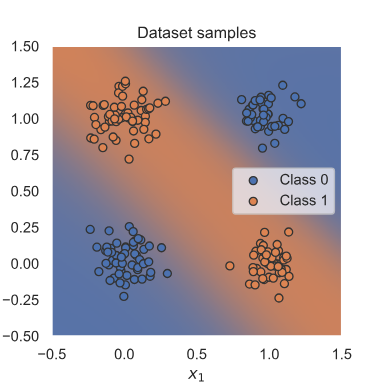

## The model

Let's find the useful classes in the torch.nn package. 

In [27]:
import torch.nn as nn

It also exists torch.nn.functional. It contains functions that are used in network layers. This is in contrast to torch.nn which defines them as nn.Modules and torch.nn actually uses a lot of functionalities from torch.nn.functional. As it is useful we import it as well.

In [28]:
import torch.nn.functional as F

### nn.Module
In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:


In [29]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

the forward function is were the computation of the module is taking place and is executed when you call the module. In the init function, we usually create the parameters of the module, using nn.Parameter, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted. 

Let's now create our own pre-defined modules in the torch.nn package and then our NN. Let's use a minima network with an input layer with 2 neurons, one hidden layer with 4 neurons and tanh as activation function and a output layer with 1 neuron.

In [30]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [31]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


To obtain the parameters of a module, we can call paremeters() functions or named_parameters().

In [32]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shampe{param.shape}")

Parameter linear1.weight, shampetorch.Size([4, 2])
Parameter linear1.bias, shampetorch.Size([4])
Parameter linear2.weight, shampetorch.Size([1, 4])
Parameter linear2.bias, shampetorch.Size([1])


Each linear layer has a weight matrix of the shape [output, input], and a bias of the shape [output]. The tanh activation function does not have any parameters. Note that parameters are only registered for nn.Module objects that are direct object attributes, i.e. self.a = .... If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like nn.ModuleList, nn.ModuleDict and nn.Sequential, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there.

### Data
PyTorch provides a few functionalities to load the training and test data efficiently, summarized in the package torch.utils.data

In [33]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: data.Dataset, and data.DataLoader. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: __getitem__, and __len__. The get-item function has to return the  𝑖 -th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [34]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        """
        Inputs: 
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y that can be either 0 or 1
        # The label is their XOR combination, ie 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size,2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # if we have multiple things to return (data point and label), we can return them as tuple
        data_point=self.data[idx]
        data_label=self.label[idx]
        return data_point,data_label

Let's try to create such a dataset and inspect it:

In [35]:
dataset = XORDataset(size=200)
print(f"Size of dataset", len(dataset))
print(f"Data point 0:", dataset[0])

Size of dataset 200
Data point 0: (tensor([1.1625, 0.0134]), tensor(1))


In [ ]:
To better relate the dataset, we visualize the samples below:

In [36]:
def visualize_samples(data,label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]



In [37]:
## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

In [38]:
visualize_samples(dataset.data, dataset.label)
plt.show()